## I. Preprocessing

Se cargan las librerías necesarias:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
import warnings
import shap
warnings.filterwarnings("ignore")
from imblearn.over_sampling import BorderlineSMOTE
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, silhouette_score, recall_score, precision_score, make_scorer, \
accuracy_score, roc_auc_score, plot_confusion_matrix, f1_score, precision_recall_curve, plot_roc_curve, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV

Procedemos a usar una muestra reducida de 100.000 datos ya que aunque hemos conseguido obtener un dataset más amplio (aproximadamente 2.500.000 datos), nuestros ordenadores no han sido capaces de computar tal cantidad de datos.

In [79]:
import os

In [80]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('../data/df_final.csv')

In [81]:
df.shape

(64513, 17)

In [82]:
df.head()

,fallecidos,n_personas,edad,todos_con_seguridad,C_MNTH,C_WDAY,C_HOUR,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,sexo_M
0,0,1,17.0,False,1,1.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,18.0,6,1991.0,0
1,0,1,30.0,True,1,1.0,0.0,1.0,1.0,1.0,1.0,5.0,1.0,18.0,1,1981.0,1
2,0,1,20.0,False,1,1.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,18.0,1,1990.0,1
3,0,1,NaN,False,1,1.0,0.0,1.0,1.0,1.0,6.0,3.0,2.0,18.0,1,NaN,0
4,0,1,36.0,False,1,1.0,0.0,1.0,1.0,NaN,1.0,2.0,3.0,18.0,1,1986.0,1


In [83]:
df.isna().sum()

fallecidos                0
n_personas                0
edad                   2407
todos_con_seguridad       0
C_MNTH                    0
C_WDAY                  130
C_HOUR                  557
C_VEHS                    5
C_CONF                 4353
C_RCFG                 9570
C_WTHR                 1375
C_RSUR                 4151
C_RALN                 6115
C_TRAF                 3083
V_TYPE                    0
V_YEAR                 4266
sexo_M                    0
dtype: int64

### Variable Recategorization

Recategorizamos ciertas variables. En el caso de C_HOUR, C_WDAY y C_MNTH se ha procedido a dividirlas en partes (por ejemplo las semanas en hábiles-fin de semana). A su vez convertimos todas las demás a string.

In [84]:
df.V_TYPE.value_counts()

1     50164
6     11165
8      1391
7      1201
11      371
9       162
5        34
18       13
23       12
Name: V_TYPE, dtype: int64

In [85]:
df.head()

,fallecidos,n_personas,edad,todos_con_seguridad,C_MNTH,C_WDAY,C_HOUR,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,sexo_M
0,0,1,17.0,False,1,1.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,18.0,6,1991.0,0
1,0,1,30.0,True,1,1.0,0.0,1.0,1.0,1.0,1.0,5.0,1.0,18.0,1,1981.0,1
2,0,1,20.0,False,1,1.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,18.0,1,1990.0,1
3,0,1,NaN,False,1,1.0,0.0,1.0,1.0,1.0,6.0,3.0,2.0,18.0,1,NaN,0
4,0,1,36.0,False,1,1.0,0.0,1.0,1.0,NaN,1.0,2.0,3.0,18.0,1,1986.0,1


In [86]:
df.C_HOUR = pd.cut(df.C_HOUR, bins=[-np.Inf, 8, 16, np.Inf], labels=['Early Morning (0-8)', 'Morning/Afternoon (8-18)', 'Evening/Night (18-24)'])
df.C_WDAY = pd.cut(df.C_WDAY, bins=[-np.Inf, 5, np.Inf], labels=['Workday', 'Weekend'])
df.C_MNTH = pd.cut(df.C_MNTH, bins=[-np.Inf, 3, 6, 9, np.Inf], labels=['Winter', 'Spring', 'Summer', 'Autumn'])
df.V_TYPE = pd.to_numeric(df.V_TYPE, downcast='integer')
df.C_RALN = pd.to_numeric(df.C_RALN, downcast='integer')
df.C_RSUR = pd.to_numeric(df.C_RSUR, downcast='integer')
df.C_WTHR = pd.to_numeric(df.C_WTHR, downcast='integer')
df.C_RCFG = pd.to_numeric(df.C_RCFG, downcast='integer')
df.C_CONF = pd.to_numeric(df.C_CONF, downcast='integer')
df.C_VEHS = pd.to_numeric(df.C_VEHS, downcast='integer')

In [87]:
df.isna().sum()

fallecidos                0
n_personas                0
edad                   2407
todos_con_seguridad       0
C_MNTH                    0
C_WDAY                  130
C_HOUR                  557
C_VEHS                    5
C_CONF                 4353
C_RCFG                 9570
C_WTHR                 1375
C_RSUR                 4151
C_RALN                 6115
C_TRAF                 3083
V_TYPE                    0
V_YEAR                 4266
sexo_M                    0
dtype: int64

In [88]:
df.dtypes

fallecidos                int64
n_personas                int64
edad                    float64
todos_con_seguridad        bool
C_MNTH                 category
C_WDAY                 category
C_HOUR                 category
C_VEHS                  float64
C_CONF                  float64
C_RCFG                  float64
C_WTHR                  float64
C_RSUR                  float64
C_RALN                  float64
C_TRAF                  float64
V_TYPE                     int8
V_YEAR                  float64
sexo_M                    int64
dtype: object

In [89]:
df.head()

,fallecidos,n_personas,edad,todos_con_seguridad,C_MNTH,C_WDAY,C_HOUR,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,sexo_M
0,0,1,17.0,False,Winter,Workday,Early Morning (0-8),1.0,1.0,1.0,1.0,4.0,1.0,18.0,6,1991.0,0
1,0,1,30.0,True,Winter,Workday,Early Morning (0-8),1.0,1.0,1.0,1.0,5.0,1.0,18.0,1,1981.0,1
2,0,1,20.0,False,Winter,Workday,Early Morning (0-8),1.0,1.0,1.0,2.0,1.0,1.0,18.0,1,1990.0,1
3,0,1,NaN,False,Winter,Workday,Early Morning (0-8),1.0,1.0,1.0,6.0,3.0,2.0,18.0,1,NaN,0
4,0,1,36.0,False,Winter,Workday,Early Morning (0-8),1.0,1.0,NaN,1.0,2.0,3.0,18.0,1,1986.0,1


In [90]:
C_CONF_replacement = {1: 'Hit a moving object E.g. a person or an animal',
2: 'Hit a stationary object E.g. a tree',
3: 'Ran off left shoulder Including rollover in the left ditch',
4: 'Ran off right shoulder Including rollover in the right ditch',
5: 'Rollover on roadway',
6: 'Any other single vehicle collision configuration',
21: 'Rear-end collision',
22: 'Side swipe',
23: 'One vehicle passing to the left of the other, or left turn conflict',
24: 'One vehicle passing to the right of the other, or right turn conflict',
25: 'Any other two vehicle - same direction of travel configuration',
31: 'Head-on collision',
32: 'Approaching side-swipe',
33: 'Left turn across opposing traffic',
34: 'Right turn, including turning conflicts',
35: 'Right angle collision',
36: 'Any other two-vehicle - different direction of travel configuration',
41: 'Hit a parked motor vehicle'}

In [91]:
df['C_CONF'] = df.C_CONF.replace(C_CONF_replacement)

In [92]:
C_RCFG_replacement = {1: 'Non-intersection e.g. mid-block',
2: 'At an intersection of at least two public roadways',
3: 'Intersection with parking lot entrance/exit, private driveway or laneway',
4: 'Railroad level crossing',
5: 'Bridge, overpass, viaduct',
6: 'Tunnel or underpass',
7: 'Passing or climbing lane',
8: 'Ramp',
9: 'Traffic circle',
10: 'Express lane of a freeway system',
11: 'Collector lane of a freeway system',
12: 'Transfer lane of a freeway system'}

In [93]:
df['C_RCFG'] = df.C_RCFG.replace(C_RCFG_replacement)

In [94]:
C_WTHR_replacement = {1: 'Clear and sunny',
2: 'Overcast, cloudy but no precipitation',
3: 'Raining',
4: 'Snowing, not including drifting snow',
5: 'Freezing rain, sleet, hail',
6: 'Visibility limitation e.g. drifting snow, fog, smog, dust, smoke, mist',
7: 'Strong wind'}

In [95]:
df['C_WTHR'] = df.C_WTHR.replace(C_WTHR_replacement)

In [96]:
C_RSUR_replacement = {1: 'Dry, normal',
2: 'Wet',
3: 'Snow (fresh, loose snow)',
4: 'Slush, wet snow',
5: 'Icy. Includes packed snow',
6: 'Sand/gravel/dirt. Refers to the debris on the road, not the material used to construct the road',
7: 'Muddy',
8: 'Oil. Includes spilled liquid or road application.',
9: 'Flooded'}

In [97]:
df['C_RSUR'] = df.C_RSUR.replace(C_RSUR_replacement)

In [98]:
C_RALN_replacement = {1: 'Straight and level',
2: 'Straight with gradient',
3: 'Curved and level',
4: 'Curved with gradient',
5: 'Top of hill or gradient',
6: 'Bottom of hill or gradient (sag):'}

In [99]:
df['C_RALN'] = df.C_RALN.replace(C_RALN_replacement)

In [100]:
C_TRAF_replacement = {1: 'Traffic signals fully operational',
2: 'Traffic signals in flashing mode',
3: 'Stop sign',
4: 'Yield sign',
5: 'Warning sign Yellow diamond shape sign',
6: 'Pedestrian crosswalk',
7: 'Police officer',
8: 'School guard, flagman',
9: 'School crossing',
10: 'Reduced speed zone',
11: 'No passing zone sign',
12: 'Markings on the road e.g. no passing',
13: 'School bus stopped with school bus signal lights flashing',
14: 'School bus stopped with school bus signal lights not flashing',
15: 'Railway crossing with signals, or signals and gates',
16: 'Railway crossing with signs only',
17: 'Control device not specified',
18: 'No control present'}

In [101]:
df['C_TRAF'] = df.C_TRAF.replace(C_TRAF_replacement)

In [102]:
V_TYPE_replacement = {1: 'Light Duty Vehicle (Passenger car, Passenger van, Light utility vehicles and light duty pick up trucks)',
5: 'Panel/cargo van <= 4536 KG GVWR. Panel or window type of van designed primarily for carrying goods.',
6: 'Other trucks and vans <= 4536 KG GVWR. Unspecified, or any other types of LTVs that do not fit into the above categories(e.g.. delivery or service vehicles, chip wagons, small tow trucks etc.)',
7: 'Unit trucks > 4536 KG GVWR. All heavy unit trucks, with or without a trailer',
8: 'Road tractor. With or without a semi-trailer',
9: 'School bus. Standard large type',
10: 'Smaller school bus. Smaller type, seats < 25 passengers',
11: 'Urban and Intercity Bus',
14: 'Motorcycle and moped. Motorcycle and limited-speed motorcycle',
16: 'Off road vehicles. Off road motorcycles (e.g. dirt bikes) and all terrain vehicles',
17: 'Bicycle',
18: 'Purpose-built motorhome. Exclude pickup campers',
19: 'Farm equipment',
20: 'Construction equipment',
21: 'Fire engine',
22: 'Snowmobile',
23: 'Street car'}

In [103]:
df['V_TYPE'] = df.V_TYPE.replace(V_TYPE_replacement)

In [104]:
df

,fallecidos,n_personas,edad,todos_con_seguridad,C_MNTH,C_WDAY,C_HOUR,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,sexo_M
0,0,1,17.0,False,Winter,Workday,Early Morning (0-8),1.0,Hit a moving object E.g. a person or an animal,Non-intersection e.g. mid-block,Clear and sunny,"Slush, wet snow",Straight and level,No control present,Other trucks and vans <= 4536 KG GVWR. Unspeci...,1991.0,0
1,0,1,30.0,True,Winter,Workday,Early Morning (0-8),1.0,Hit a moving object E.g. a person or an animal,Non-intersection e.g. mid-block,Clear and sunny,Icy. Includes packed snow,Straight and level,No control present,"Light Duty Vehicle (Passenger car, Passenger v...",1981.0,1
2,0,1,20.0,False,Winter,Workday,Early Morning (0-8),1.0,Hit a moving object E.g. a person or an animal,Non-intersection e.g. mid-block,"Overcast, cloudy but no precipitation","Dry, normal",Straight and level,No control present,"Light Duty Vehicle (Passenger car, Passenger v...",1990.0,1
3,0,1,NaN,False,Winter,Workday,Early Morning (0-8),1.0,Hit a moving object E.g. a person or an animal,Non-intersection e.g. mid-block,"Visibility limitation e.g. drifting snow, fog,...","Snow (fresh, loose snow)",Straight with gradient,No control present,"Light Duty Vehicle (Passenger car, Passenger v...",NaN,0
4,0,1,36.0,False,Winter,Workday,Early Morning (0-8),1.0,Hit a moving object E.g. a person or an animal,NaN,Clear and sunny,Wet,Curved and level,No control present,"Light Duty Vehicle (Passenger car, Passenger v...",1986.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64508,0,1,21.0,False,Spring,Workday,Evening/Night (18-24),1.0,Hit a moving object E.g. a person or an animal,At an intersection of at least two public road...,Clear and sunny,"Dry, normal",Straight and level,Stop sign,"Light Duty Vehicle (Passenger car, Passenger v...",1989.0,1
64509,0,2,NaN,True,Spring,Workday,Evening/Night (18-24),1.0,Hit a moving object E.g. a person or an animal,"Intersection with parking lot entrance/exit, p...",Clear and sunny,"Dry, normal",Straight and level,No control present,Other trucks and vans <= 4536 KG GVWR. Unspeci...,1993.0,0
64510,0,1,22.0,False,Spring,Workday,Evening/Night (18-24),1.0,Ran off left shoulder Including rollover in th...,Non-intersection e.g. mid-block,Clear and sunny,"Dry, normal",Straight and level,No control present,"Light Duty Vehicle (Passenger car, Passenger v...",1986.0,1
64511,0,2,45.0,True,Spring,Workday,Evening/Night (18-24),1.0,Ran off left shoulder Including rollover in th...,Non-intersection e.g. mid-block,Clear and sunny,"Dry, normal",Curved with gradient,No control present,"Light Duty Vehicle (Passenger car, Passenger v...",1988.0,1


In [105]:
df.sexo_M = df.sexo_M.replace({0: 'Female', 1: 'Male'})

In [106]:
df.todos_con_seguridad = df.todos_con_seguridad.replace({False: 'No', True: 'Yes'})

In [107]:
df.columns

Index(['fallecidos', 'n_personas', 'edad', 'todos_con_seguridad', 'C_MNTH',
       'C_WDAY', 'C_HOUR', 'C_VEHS', 'C_CONF', 'C_RCFG', 'C_WTHR', 'C_RSUR',
       'C_RALN', 'C_TRAF', 'V_TYPE', 'V_YEAR', 'sexo_M'],
      dtype='object')

In [108]:
fecha = '15-1-2022'

In [109]:
fecha = pd.to_datetime(fecha)

In [110]:
df.rename(columns={'n_personas': 'Number of People', 'edad': 'Age', 'todos_con_seguridad':'Everyone with Seat Belt', 'sexo_M': 'Gender'}, inplace=True)

In [111]:
for i in df.columns:
    if df[i].dtypes == object:
        print(f'{i} = "{df[i][2]}"')
    else:
        print(f'{i} = {df[i][2]}') 

fallecidos = 0
Number of People = 1
Age = 20.0
Everyone with Seat Belt = "No"
C_MNTH = Winter
C_WDAY = Workday
C_HOUR = Early Morning (0-8)
C_VEHS = 1.0
C_CONF = "Hit a moving object E.g. a person or an animal"
C_RCFG = "Non-intersection e.g. mid-block"
C_WTHR = "Overcast, cloudy but no precipitation"
C_RSUR = "Dry, normal"
C_RALN = "Straight and level"
C_TRAF = "No control present"
V_TYPE = "Light Duty Vehicle (Passenger car, Passenger van, Light utility vehicles and light duty pick up trucks)"
V_YEAR = 1990.0
Gender = "Male"


In [112]:
fallecidos = 0
Number_of_People = 1
Age = 20.0
Everyone_with_Seat_Belt = "No"
C_MNTH = 'Winter'
C_WDAY = 'Workday'
C_HOUR = 'Early Morning (0-8)'
C_VEHS = 1.0
C_CONF = "Hit a moving object E.g. a person or an animal"
C_RCFG = "Non-intersection e.g. mid-block"
C_WTHR = "Overcast, cloudy but no precipitation"
C_RSUR = "Dry, normal"
C_RALN = "Straight and level"
C_TRAF = "No control present"
V_TYPE = "Light Duty Vehicle (Passenger car, Passenger van, Light utility vehicles and light duty pick up trucks)"
V_YEAR = 1990.0
Gender = "Male"

In [113]:
df.C_MNTH = df.C_MNTH.astype(object)
df.C_WDAY = df.C_WDAY.astype(object)
df.C_HOUR = df.C_HOUR.astype(object)

### Dummy Variables

Se procede a realizar la técnica de variables dummy, ya que no era posible realizar el OneHot Encoding.

In [114]:
from sklearn.preprocessing import OneHotEncoder

In [115]:
ohe = OneHotEncoder(sparse=False, drop='first')

In [116]:
X = df.drop(columns='fallecidos')
y = df.fallecidos

In [117]:
Xcat = X.select_dtypes(object)
Xnum = X.select_dtypes(exclude=object)

In [118]:
Xcat_dum = ohe.fit_transform(Xcat)

In [119]:
Xcat_dum.shape

(64513, 79)

In [120]:
Xcat_dum.shape

(64513, 79)

In [121]:
X_dum = np.concatenate([Xcat_dum, Xnum], axis=1)

### Para Prediccion

In [122]:
datainput = {'Number of People': Number_of_People,
'Age': Age,
'Everyone with Seat Belt': Everyone_with_Seat_Belt,
'C_MNTH': C_MNTH,
'C_WDAY': C_WDAY,
'C_HOUR': C_HOUR,
'C_VEHS': C_VEHS,
'C_CONF': C_CONF,
'C_RCFG': C_RCFG,
'C_WTHR': C_WTHR,
'C_RSUR': C_RSUR,
'C_RALN': C_RALN,
'C_TRAF': C_TRAF,
'V_TYPE': V_TYPE,
'V_YEAR': V_YEAR,
'Gender': Gender}

In [123]:
Xinput = pd.DataFrame(datainput, index=[0])

In [124]:
Xinput_cat = Xinput.select_dtypes(object)
Xinput_num = Xinput.select_dtypes(exclude=object)

In [125]:
Xinput_cat_dum = ohe.transform(Xinput_cat)

In [126]:
Xinput_cat_dum.shape

(1, 79)

In [127]:
Xinput_dum = np.concatenate([Xinput_cat_dum, Xinput_num], axis=1)

In [128]:
Xinput_dum.shape

(1, 83)

### Imputar NAs

Se imputan los NAs del DataFrame mediante la técnica de k-NearestNeighbours, seleccionando los 10 vecinos más cercanos.

In [129]:
imputer = KNNImputer(n_neighbors=10)
X_dum = imputer.fit_transform(X_dum)

In [130]:
(X_dum == np.nan).sum()

0

In [131]:
pd.DataFrame(X_dum)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17.0,1.0,1991.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,30.0,1.0,1981.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,20.0,1.0,1990.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37.2,1.0,1993.7
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,36.0,1.0,1986.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64508,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,21.0,1.0,1989.0
64509,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,29.5,1.0,1993.0
64510,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,22.0,1.0,1986.0
64511,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,45.0,1.0,1988.0


### Para Formulario

In [132]:
Xcat.isna().sum()

Everyone with Seat Belt       0
C_MNTH                        0
C_WDAY                      130
C_HOUR                      557
C_CONF                     4353
C_RCFG                     9570
C_WTHR                     1375
C_RSUR                     4151
C_RALN                     6115
C_TRAF                     3083
V_TYPE                        0
Gender                        0
dtype: int64

In [141]:
ohe.feature_names_in_

array(['Everyone with Seat Belt', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'C_CONF',
       'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_TYPE',
       'Gender'], dtype=object)

In [145]:
{k:v for k,v in zip(ohe.feature_names_in_, ohe.categories_)}

{'Everyone with Seat Belt': array(['No', 'Yes'], dtype=object),
 'C_MNTH': array(['Spring', 'Winter'], dtype=object),
 'C_WDAY': array(['Weekend', 'Workday', nan], dtype=object),
 'C_HOUR': array(['Early Morning (0-8)', 'Evening/Night (18-24)',
        'Morning/Afternoon (8-18)', nan], dtype=object),
 'C_CONF': array(['Any other single vehicle collision configuration',
        'Any other two vehicle - same direction of travel configuration',
        'Any other two-vehicle - different direction of travel configuration',
        'Approaching side-swipe', 'Head-on collision',
        'Hit a moving object E.g. a person or an animal',
        'Hit a parked motor vehicle',
        'Hit a stationary object E.g. a tree',
        'Left turn across opposing traffic',
        'One vehicle passing to the left of the other, or left turn conflict',
        'One vehicle passing to the right of the other, or right turn conflict',
        'Ran off left shoulder Including rollover in the left ditch',
  

In [146]:
dic_cat = {i:Xcat[i].dropna().unique().tolist() for i in Xcat}

In [147]:
lis_num = Xnum.columns.to_list()

In [148]:
dic_cat

{'Everyone with Seat Belt': ['No', 'Yes'],
 'C_MNTH': ['Winter', 'Spring'],
 'C_WDAY': ['Workday', 'Weekend'],
 'C_HOUR': ['Early Morning (0-8)',
  'Morning/Afternoon (8-18)',
  'Evening/Night (18-24)'],
 'C_CONF': ['Hit a moving object E.g. a person or an animal',
  'Ran off right shoulder Including rollover in the right ditch',
  'Rear-end collision',
  'Right turn, including turning conflicts',
  'Right angle collision',
  'Hit a parked motor vehicle',
  'Hit a stationary object E.g. a tree',
  'Any other single vehicle collision configuration',
  'Ran off left shoulder Including rollover in the left ditch',
  'Head-on collision',
  'Side swipe',
  'Left turn across opposing traffic',
  'Rollover on roadway',
  'Approaching side-swipe',
  'One vehicle passing to the left of the other, or left turn conflict',
  'Any other two-vehicle - different direction of travel configuration',
  'One vehicle passing to the right of the other, or right turn conflict',
  'Any other two vehicle - sa

In [149]:
import pickle

In [150]:
with open('../model_deployment/model/dic_cat.pkl', 'wb') as f:
    pickle.dump(dic_cat, f)

In [151]:
with open('../model_deployment/model/lis_num.pkl', 'wb') as f:
    pickle.dump(lis_num, f)

In [152]:
with open('../model_deployment/model/ohe.pkl', 'wb') as f:
    pickle.dump(ohe, f)

### Feature Selection

Se procede a seleccionar las distintas variables clave en nuestro modelo. Por un lado la y (variable objetivo del modelo) que va a ser 'fallecidos'. Es decir, la antigua variable 'C_SEV'. En este caso si en un accidente se fallece o no. Por otro lado la X (variables explicativas), las demás del DataFrame que explicarán la objetivo.

In [269]:
y.value_counts()

0    64071
1      442
Name: fallecidos, dtype: int64

### Distribución de los datos

Se comprueba la distribución de los datos y como están altamente desbalanceados, se representan graficamente.

In [270]:
df.fallecidos.value_counts(normalize=True)*100

0    99.314867
1     0.685133
Name: fallecidos, dtype: float64

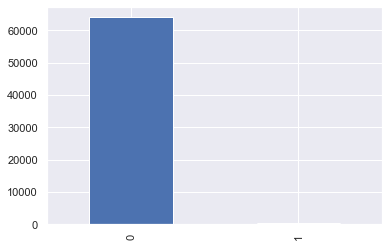

In [271]:
plt.figure(figsize=(6,4))
df.fallecidos.value_counts().plot(kind='bar');

### SMOTE

Procedemos al balanceo de los datos mediante la técnica BorderlineSMOTE.

In [273]:
oversample = BorderlineSMOTE()
X, y = oversample.fit_resample(X_dum, y)

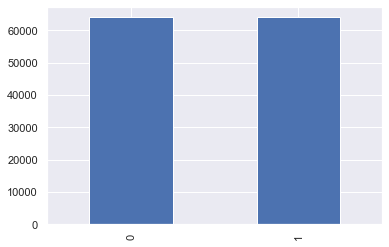

In [274]:
plt.figure(figsize=(6,4))
y.value_counts().plot(kind='bar');

### División train-test

Dividimos el dataset en train y test

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## II. Modelado

### Definición de las funciones para la estructura y cálculo de los distintos modelos

In [281]:
def model_function(y_test, y_pred):
    
    print('Accuracy: {}\n'.format(accuracy_score(y_test, y_pred)))
    
    score = f1_score(y_test, y_pred)
    print('F1-Score: %.5f' % score)

    print('Classification report: \n{}\n'.format(classification_report(y_test, y_pred)))
    
    print('Confusion matrix:')
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='YlGnBu');
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show();

In [282]:
def models(model):
    
    model.fit(X_train, y_train)   
    print("Model score: %.3f" % model.score(X_test, y_test))
    
    y_pred = model.predict(X_test)
    
    model_function(y_test=y_test, y_pred=y_pred)

### 1) Modelo base (al azar)

Accuracy: 0.4972036521603413

F1-Score: 0.49589
Classification report: 
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     19349
           1       0.49      0.50      0.50     19094

    accuracy                           0.50     38443
   macro avg       0.50      0.50      0.50     38443
weighted avg       0.50      0.50      0.50     38443


Confusion matrix:


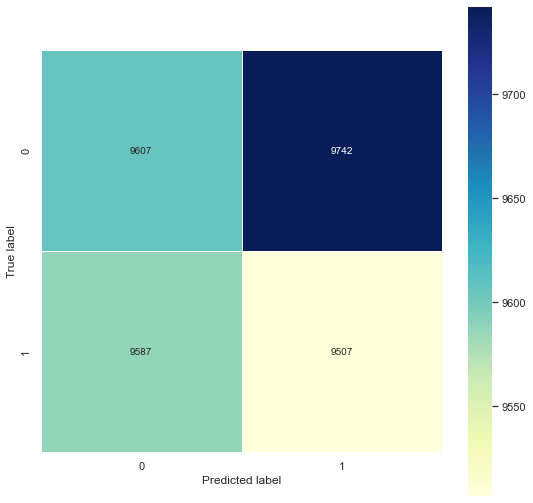

In [283]:
random_list = []
for i in range(0, len(y_test)):
    n = random.randint(0,1)
    random_list.append(n)
    
model_function(y_test, y_pred=random_list)

### 2) Modelo Regresión Logística

In [284]:
lr = LogisticRegression()

Model score: 0.840
Accuracy: 0.8401009286476081

F1-Score: 0.84029
Classification report: 
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     19349
           1       0.83      0.85      0.84     19094

    accuracy                           0.84     38443
   macro avg       0.84      0.84      0.84     38443
weighted avg       0.84      0.84      0.84     38443


Confusion matrix:


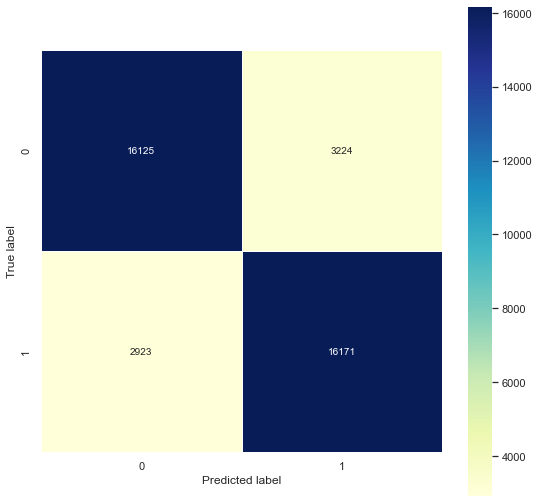

In [285]:
models(lr)

### 3) Modelo Decision Tree

In [ ]:
dt = DecisionTreeClassifier()

Model score: 0.991
Accuracy: 0.9907915615326588

F1-Score: 0.99076
Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19349
           1       0.99      0.99      0.99     19094

    accuracy                           0.99     38443
   macro avg       0.99      0.99      0.99     38443
weighted avg       0.99      0.99      0.99     38443


Confusion matrix:


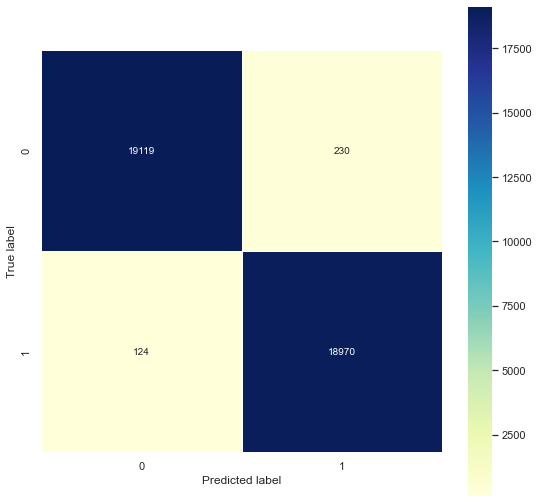

In [287]:
models(dt)

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(decision_tree=dt, max_depth=2, feature_names=X.columns, filled=True);

### 4) Modelo XGBoost

In [289]:
xgb =  XGBClassifier()

[23:11:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model score: 0.997
Accuracy: 0.9969045079728429

F1-Score: 0.99687
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19349
           1       1.00      0.99      1.00     19094

    accuracy                           1.00     38443
   macro avg       1.00      1.00      1.00     38443
weighted avg       1.00      1.00      1.00     38443


Confusion matrix:


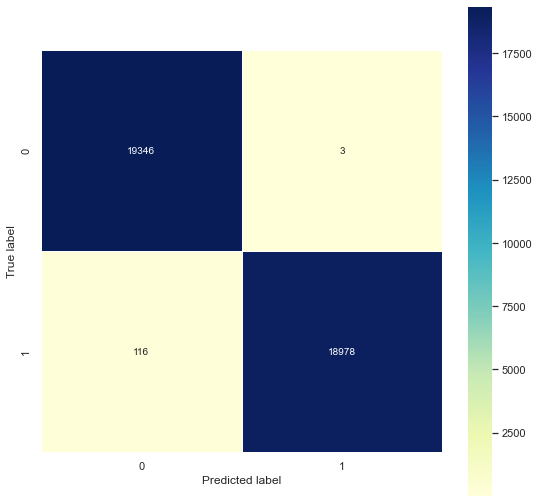

In [290]:
models(xgb)

### 5) Modelo LightGBM

In [291]:
lgbm = LGBMClassifier(random_state=123)

Model score: 0.997
Accuracy: 0.9968264703587129

F1-Score: 0.99680
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19349
           1       1.00      0.99      1.00     19094

    accuracy                           1.00     38443
   macro avg       1.00      1.00      1.00     38443
weighted avg       1.00      1.00      1.00     38443


Confusion matrix:


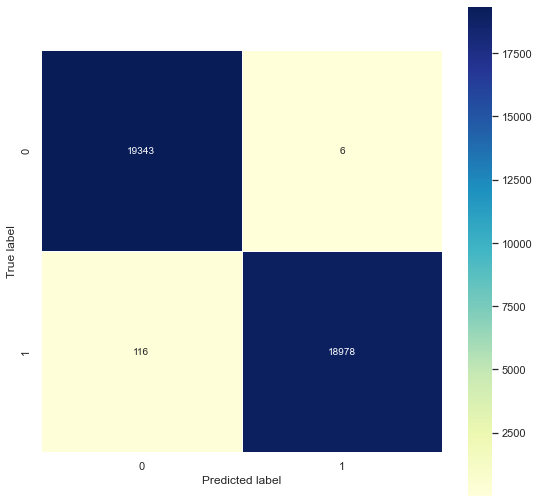

In [292]:
models(lgbm)

### 6) Modelo Random Forest

In [293]:
rf = RandomForestClassifier(random_state=123)

Model score: 0.997
Accuracy: 0.9966443825924095

F1-Score: 0.99661
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19349
           1       1.00      0.99      1.00     19094

    accuracy                           1.00     38443
   macro avg       1.00      1.00      1.00     38443
weighted avg       1.00      1.00      1.00     38443


Confusion matrix:


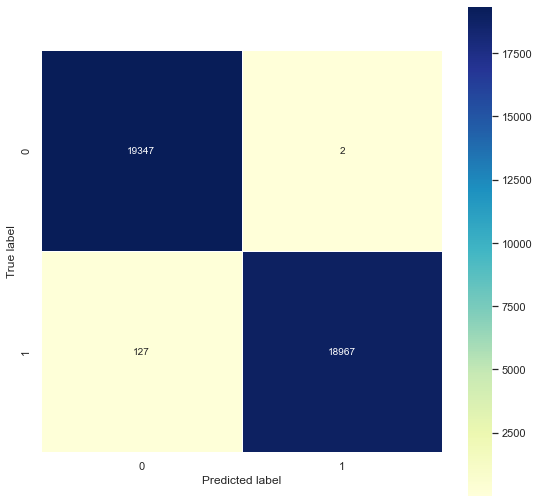

In [294]:
models(rf)

Nuestro modelo elegido que mejor predice es el Random Forest. Procedemos a buscar los hiperparámetros más óptimos del modelo por si se pudiera mejorar el modelo.

#### Optimización de hiperparámetros

In [73]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [74]:
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20, 40, 80], 'max_features': ['auto', 3, 5, 7]}

In [75]:
cv = GridSearchCV(estimator=rf, param_grid=param_grid, verbose=2)

In [76]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END .....criterion=gini, max_depth=5, max_features=auto; total time=   3.1s
[CV] END .....criterion=gini, max_depth=5, max_features=auto; total time=   3.1s
[CV] END .....criterion=gini, max_depth=5, max_features=auto; total time=   3.1s
[CV] END .....criterion=gini, max_depth=5, max_features=auto; total time=   3.1s
[CV] END .....criterion=gini, max_depth=5, max_features=auto; total time=   3.1s
[CV] END ........criterion=gini, max_depth=5, max_features=3; total time=   1.8s
[CV] END ........criterion=gini, max_depth=5, max_features=3; total time=   1.8s
[CV] END ........criterion=gini, max_depth=5, max_features=3; total time=   1.8s
[CV] END ........criterion=gini, max_depth=5, max_features=3; total time=   1.8s
[CV] END ........criterion=gini, max_depth=5, max_features=3; total time=   1.8s
[CV] END ........criterion=gini, max_depth=5, max_features=5; total time=   2.3s
[CV] END ........criterion=gini, max_depth=5, m

GridSearchCV(estimator=RandomForestClassifier(random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 40, 80],
                         'max_features': ['auto', 3, 5, 7]},
             verbose=2)

In [77]:
cv.best_params_

{'criterion': 'gini', 'max_depth': 40, 'max_features': 'auto'}

In [295]:
rf = RandomForestClassifier(criterion='entropy', max_depth=80, max_features=7)

Model score: 0.997
Accuracy: 0.9967484327445829

F1-Score: 0.99672
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19349
           1       1.00      0.99      1.00     19094

    accuracy                           1.00     38443
   macro avg       1.00      1.00      1.00     38443
weighted avg       1.00      1.00      1.00     38443


Confusion matrix:


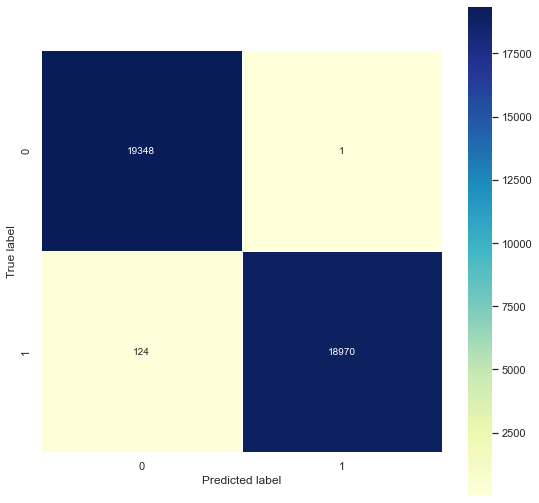

In [296]:
models(rf)

In [334]:
with open('../model_deployment/model/model.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [333]:
rf

RandomForestClassifier(criterion='entropy', max_depth=80, max_features=7)

## III. Interpretabilidad

### Feature Importance

Realizamos este gráfico para mostrar las variables en orden de importancia.

En primer lugar tenemos la variable 'C_CONF' que explica el tipo o configuración de la colisión en el accidente, y supone la caracteristica más relevante a la hora de segregar dentro del modelo. En segundo lugar tenemos 'n_personas', que mide el número de personas involucradas en el accidente, seguido de 'C_TRAF' y 'C_RCFG'.

In [ ]:
(pd.Series(rf.feature_importances_, index=X.columns)
   .nlargest(15)
   .plot(kind='barh'))  

### SHAP Values

Para la interpretabilidad local utilizaremos el método SHAP. El método Shap es un metodo para explicar las predicciones individuales, se basa en los valores de Shapley.

In [81]:
shap.initjs()

In [83]:
explainer = shap.TreeExplainer(rf)

In [84]:
shap_values=explainer.shap_values(X_train.iloc[0:100,:])

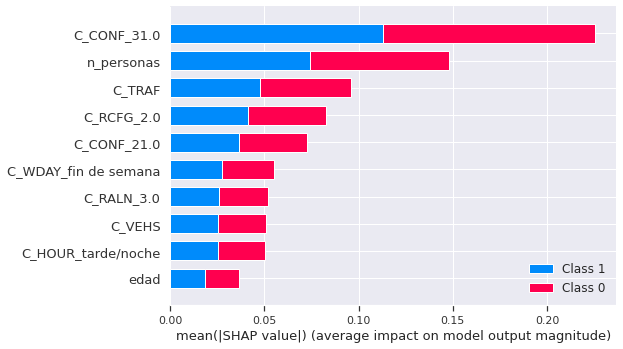

In [126]:
shap.summary_plot(shap_values, features=X_train.iloc[0:100,:], max_display=10)

Este gráfico nos muestra donde el eje de las 'x' corresponde al valor del SHAP, y el eje de las 'y' corresponde a las variables ordenadas por importancia.

En este caso, tomamos las 10 más importantes, y en función de los colores rojo (high) y azul (low) sabemos el efecto que de dicha variable sobre el valor SHAP.
El valor del SHAP esta correlacionado con el score de nuestro modelo predictivo de la siguiente forma: valores de SHAP bajos contribuyen hacia un score de cero y valores de SHAP alto hacía un score más cercano uno.

Si un mismo color esta presente a ambos lados (partiendo del valor SHAP = 0), esto supone que esos valores (sean altos o bajos) contribuyen de la misma forma tanto a que el score sea cero como uno, lo que nos informa de la neutralidad de la variable en este sentido. Este ejemplo se ve claramente en el caso de la variable C_HOUR.

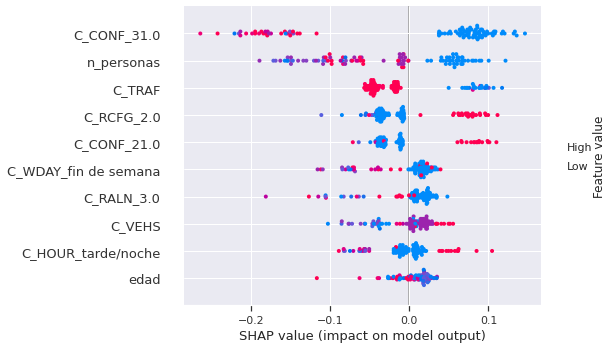

In [87]:
shap.summary_plot(shap_values[0], features=X_train.iloc[0:100,:], max_display=10)

In [128]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_train.iloc[0,:])

En el gráfico anterior se detalla esta influencia anteriormente descrita de las variables sobre los valores SHAP y el score del modelo a nivel de fila, tomando únicamente en este caso el primer registro.

In [130]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:100,:], features=X_train.iloc[:100, :])

En este gráfico obtenemos una representación equivalente a la anterior pero a nivel agregado de los cien primeros registros, que ha sido el total utilizado para calcular los valores SHAP.